In [5]:
from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/Shareddrives/EE147

Mounted at /content/drive
/content/drive/Shareddrives/EE147


In [6]:
## Importing the necessary packages
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, SimpleRNN, LSTM, GRU, BatchNormalization, MaxPooling1D, MaxPooling2D, Reshape, Permute
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal

from utils.utils import plot_accuracy_loss
import utils.dataprep as dp
import utils.person as person
import importlib
importlib.reload(dp)
importlib.reload(person)

<module 'utils.person' from '/content/drive/Shareddrives/EE147/utils/person.py'>

## Loading the dataset

In [7]:
## Loading the dataset
raw = lambda _: ()
(raw.X_train_valid, raw.y_train_valid, raw.person_train_valid), \
    (raw.X_test, raw.y_test, raw.person_test) = dp.load_data()

(raw.X_train, raw.y_train, raw.person_train), \
    (raw.X_valid, raw.y_valid, raw.person_valid) = \
    dp.split_data(raw.X_train_valid, raw.y_train_valid, raw.person_train_valid)

Loading data from /content/drive/Shareddrives/EE147/project_data/
Training/Valid data shape: (2115, 22, 1000)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000)
Test target shape: (443,)
Person test shape: (443,)
Training Data: (1692, 22, 1000) with labels (1692,) and people (1692,)
Validate Data: (423, 22, 1000) with labels (423,) and people (423,)


In [84]:
def data_prep(X, y, p=None, sub_sample=2, average=2, noise=True, noise_val=0.5, test_set=False):
    def noise(shape):
      if noise:
        return np.random.normal(0.0, noise_val, shape)
      else:
        return 0.0

    # Trimming the data
    X = X[:, :, 0:500]

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average), axis=3)
    X_average = X_average + noise(X_average.shape)

    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    X_max = signal.resample(X, 250, axis=2)
    
    # Subsampling
    X_sub = []
    y_sub = []
    p_sub = []
    for i in range(sub_sample):
        X_sub.append(X[:, :, i::sub_sample] + noise(X[:,:,i::sub_sample].shape))
        y_sub.append(y)
        p_sub.append(p)

    total_X = [X_average, X_max, *X_sub]
    total_y = [y, y, *y_sub]
    total_p = [p, p, *p_sub] if p is not None else []

    for noise_count in range(0):
      total_X.append(X_average + noise(X_average.shape))
      total_y.append(y)
      total_p.append(p)
    if test_set:
      if p is None:
        return total_X, total_y, 
      else:
        return total_X, total_y, total_p
    else:
      if p is None:
        return np.vstack(total_X), np.hstack(total_y)
      else:
        return np.vstack(total_X), np.hstack(total_y), np.hstack(total_p)

In [96]:
noise_val = 0.5
prep = lambda _: ()
prep.X_train, prep.y_train, prep.person_train = data_prep(raw.X_train, raw.y_train, raw.person_train, noise_val=noise_val)
prep.X_valid, prep.y_valid, prep.person_valid = data_prep(raw.X_valid, raw.y_valid, raw.person_valid, noise_val=noise_val)
prep.X_test,  prep.y_test,  prep.person_test  = data_prep(raw.X_test,  raw.y_test,  raw.person_test, noise_val=0.0, test_set=True)

# print('X-train', prep.X_train.shape, 'with labels', prep.y_train.shape)
# print('X-valid', prep.X_valid.shape, 'with labels', prep.y_valid.shape)
# print('X-test',  prep.X_test.shape,  'with labels', prep.y_test.shape)

#### ------------ Dimension Reshaping ------------ ####

def do_dims(X):
  # Add spare dimension at the end
  add_empty = X.reshape(*X.shape, 1)
  # Swap channels(1) with time(2)
  return np.transpose(add_empty, axes=(0,2,3,1))
def categ(y):
  return keras.utils.to_categorical(y, 4)

X_train = do_dims(prep.X_train)
X_valid = do_dims(prep.X_valid)
X_test  = [do_dims(X_test_sub) for X_test_sub in prep.X_test]

# Convert 0-3 labels to One-Hot Encoding
y_train = categ(prep.y_train)
y_valid = categ(prep.y_valid)
y_test  = [categ(y_test_sub) for y_test_sub in prep.y_test]

# Do nothing to person labels
person_train = prep.person_train
person_valid = prep.person_valid
person_test  = prep.person_test

# print('---- Reshaping Data ----')
print ("X-train", X_train.shape, "with labels", y_train.shape, "and people", person_train.shape)
print ("X-valid", X_valid.shape, "with labels", y_valid.shape, "and people", person_valid.shape)
print ("X-test",  [X_test_sub.shape for X_test_sub in X_test], \
       "with labels", [y_test_sub.shape for y_test_sub in y_test], \
       "and people", [person_test_sub.shape for person_test_sub in person_test])

X-train (6768, 250, 1, 22) with labels (6768, 4) and people (6768,)
X-valid (1692, 250, 1, 22) with labels (1692, 4) and people (1692,)
X-test [(443, 250, 1, 22), (443, 250, 1, 22), (443, 250, 1, 22), (443, 250, 1, 22)] with labels [(443, 4), (443, 4), (443, 4), (443, 4)] and people [(443,), (443,), (443,), (443,)]


## Building a basic CNN model and then training, validating and testing it.

Model     | Depth | Parameters | Accuracy Rate (%)
--------- | ----- | ---------- | -----------------
SimpleCNN | 4     | 72,879     | 70.2

In [114]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 50

def build_CNN_model():
  #Building the model
  model = Sequential()

  # First block of conv.
  model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  # Second block of conv.
  model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  # Third block of conv.
  model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  # FC layer  
  model.add(Flatten())
  model.add(Dense(4, activation='softmax'))

  # Defining the optimizer
  optimizer = keras.optimizers.Adam(lr=learning_rate)

  # Compiling the model
  model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
  return model

# Get new copy of model
cnn_model = build_CNN_model()

# Printing the model summary
cnn_model.summary()

# Training and validating the model
cnn_results = cnn_model.fit(X_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid, y_valid), verbose=True)
cnn_model.save('models/cnn')

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_45 (Dropout)         (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 1, 50)       

INFO:tensorflow:Assets written to: models/cnn/assets


Test accuracy of the CNN model on X-avg: 0.6930022835731506
Test accuracy of the CNN model on X-max: 0.6930022835731506
Test accuracy of the CNN model on X-sub0: 0.6952595710754395
Test accuracy of the CNN model on X-sub1: 0.6997742652893066
Mode Accuracy: 0.690744920993228


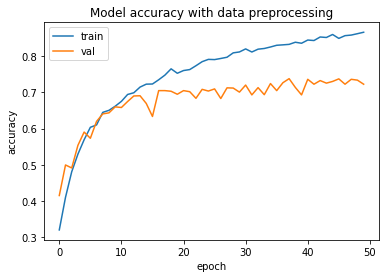

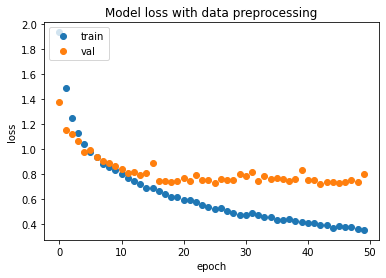

In [115]:
## Test scores for each type of augmentation
for ix, name in enumerate(["avg", "max", "sub0", "sub1"]):
  score = cnn_model.evaluate(X_test[ix], y_test[ix], verbose=0)
  print(f'Test accuracy of the CNN model on X-{name}:',score[1])

## Test scores for mode prediction over augmentations
correct = np.argmax(y_test[0], axis=1)
pred_avg = np.argmax(cnn_model(X_test[0], training=False), axis=1)
pred_max = np.argmax(cnn_model(X_test[1], training=False), axis=1)
pred_sub0 = np.argmax(cnn_model(X_test[2], training=False), axis=1)
pred_sub1 = np.argmax(cnn_model(X_test[3], training=False), axis=1)
predicted = np.vstack((pred_avg, pred_max, pred_sub0, pred_sub1)).T

predicted_mode = scs.mode(predicted, axis=1).mode.flatten()
print("Mode Accuracy:", np.sum(predicted_mode == correct) / correct.shape[0])

plot_accuracy_loss(cnn_results.history)

In [66]:
train = (X_train, y_train, person_train)
valid = (X_valid, y_valid, person_valid)
test  = (X_test[0],  y_test[0],  person_test[0])
for person_ix in range(9):
  print()
  for everyone in 0, 40, 50:
    person.question_1(build_CNN_model(), train, valid, test, person_ix, everyone_epochs=everyone)


Test accuracy of the model (0/50) on person-0: 0.62
Test accuracy of the model (40/50) on person-0: 0.84
Test accuracy of the model (50/50) on person-0: 0.68

Test accuracy of the model (0/50) on person-1: 0.56
Test accuracy of the model (40/50) on person-1: 0.68
Test accuracy of the model (50/50) on person-1: 0.7

Test accuracy of the model (0/50) on person-2: 0.7
Test accuracy of the model (40/50) on person-2: 0.84
Test accuracy of the model (50/50) on person-2: 0.82

Test accuracy of the model (0/50) on person-3: 0.68
Test accuracy of the model (40/50) on person-3: 0.86
Test accuracy of the model (50/50) on person-3: 0.7

Test accuracy of the model (0/50) on person-4: 0.77
Test accuracy of the model (40/50) on person-4: 0.83
Test accuracy of the model (50/50) on person-4: 0.74

Test accuracy of the model (0/50) on person-5: 0.63
Test accuracy of the model (40/50) on person-5: 0.73
Test accuracy of the model (50/50) on person-5: 0.73

Test accuracy of the model (0/50) on person-6: 0

## CNN-LSTM Model

RNN-Type | Depth | Parameters | Accuracy Rate (%)
-------- | ----- | ---------- | --------------
lstm     | TODO  | 61,289     | 69.3
rnn      | TODO  | 60,659     | 65.9
gru      | TODO  | 61,109     | 69.8

In [113]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 50

def build_CNN_RNN_model(rnn_selection):
  rnn_classes = {
      'rnn': SimpleRNN,
      'lstm': LSTM,
      'gru': GRU,
  }

  #Building the model
  model = Sequential()

  # First block of conv.
  model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  # Second block of conv.
  model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  # LSTM Block
  model.add(Flatten())
  model.add(Dense(30, activation='elu'))
  model.add(Reshape((3, 10)))
  model.add(rnn_classes[rnn_selection](10, dropout=0.5, recurrent_dropout=0.5, input_shape=(3,10), return_sequences=False))

  # FC layer
  model.add(Flatten())
  model.add(Dense(4, activation='softmax'))

  # Defining the optimizer
  optimizer = keras.optimizers.Adam(lr=learning_rate)

  # Compiling the model
  model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
  return model

rnn_selection = 'lstm'
cnn_lstm_model = build_CNN_RNN_model(rnn_selection)

# Printing the model summary
cnn_lstm_model.summary()

# Training and validating the model

cnn_lstm_results = cnn_lstm_model.fit(X_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid, y_valid), verbose=True)
cnn_lstm_model.save(f'models/cnn-{rnn_selection}')

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_43 (Dropout)         (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 1, 50)       

INFO:tensorflow:Assets written to: models/cnn-lstm/assets


Test accuracy of the CNN-LSTM model on X-avg: 0.6365688443183899
Test accuracy of the CNN-LSTM model on X-max: 0.6388261914253235
Test accuracy of the CNN-LSTM model on X-sub0: 0.6365688443183899
Test accuracy of the CNN-LSTM model on X-sub1: 0.6388261914253235
Mode Accuracy: 0.6343115124153499


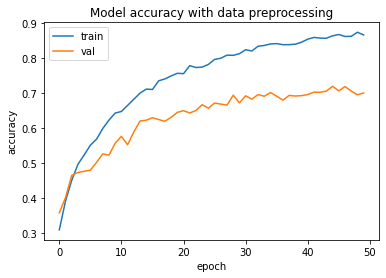

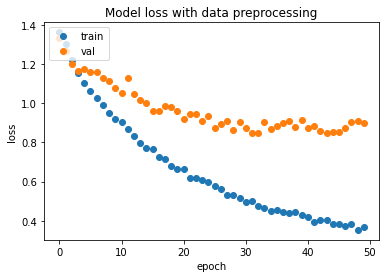

In [112]:
## Test scores for each type of augmentation
for ix, name in enumerate(["avg", "max", "sub0", "sub1"]):
  score = cnn_lstm_model.evaluate(X_test[ix], y_test[ix], verbose=0)
  print(f'Test accuracy of the CNN-LSTM model on X-{name}:',score[1])

## Test scores for mode prediction over augmentations
correct = np.argmax(y_test[0], axis=1)
pred_avg = np.argmax(cnn_lstm_model(X_test[0], training=False), axis=1)
pred_max = np.argmax(cnn_lstm_model(X_test[1], training=False), axis=1)
pred_sub0 = np.argmax(cnn_lstm_model(X_test[2], training=False), axis=1)
pred_sub1 = np.argmax(cnn_lstm_model(X_test[3], training=False), axis=1)
predicted = np.vstack((pred_avg, pred_max, pred_sub0, pred_sub1)).T

predicted_mode = scs.mode(predicted, axis=1).mode.flatten()
print("Mode Accuracy:", np.sum(predicted_mode == correct) / correct.shape[0])

plot_accuracy_loss(cnn_lstm_results.history)

In [ ]:
train = (X_train, y_train, person_train)
valid = (X_valid, y_valid, person_valid)
test  = (X_test[0],  y_test[0],  person_test[0])
rnn_type = 'lstm'
for person_ix in range(9):
  print()
  for everyone in 0, 40, 50:
    person.question_1(build_CNN_RNN_model(rnn_type), train, valid, test, person_ix, everyone_epochs=everyone)

In [ ]:
0/50:  0.6,0.52,0.5,0.6,0.74,0.59,0.58,0.48,0.72       9, 0.59, 0.085
40/50: 0.74,0.68,0.8,0.8,0.89,0.71,0.72,0.68,0.79      9, 0.76, 0.065
50/50: 0.58,0.46,0.74,0.72,0.83,0.69,0.7,0.58,0.64     9, 0.66, 0.103
Test accuracy of the model (0/50) on person-0: 0.6
Test accuracy of the model (40/50) on person-0: 0.74
Test accuracy of the model (50/50) on person-0: 0.58

Test accuracy of the model (0/50) on person-1: 0.52
Test accuracy of the model (40/50) on person-1: 0.68
Test accuracy of the model (50/50) on person-1: 0.46

Test accuracy of the model (0/50) on person-2: 0.5
Test accuracy of the model (40/50) on person-2: 0.8
Test accuracy of the model (50/50) on person-2: 0.74

Test accuracy of the model (0/50) on person-3: 0.6
Test accuracy of the model (40/50) on person-3: 0.8
Test accuracy of the model (50/50) on person-3: 0.72

Test accuracy of the model (0/50) on person-4: 0.74
Test accuracy of the model (40/50) on person-4: 0.89
Test accuracy of the model (50/50) on person-4: 0.83

Test accuracy of the model (0/50) on person-5: 0.59
Test accuracy of the model (40/50) on person-5: 0.71
Test accuracy of the model (50/50) on person-5: 0.69

Test accuracy of the model (0/50) on person-6: 0.58
Test accuracy of the model (40/50) on person-6: 0.72
Test accuracy of the model (50/50) on person-6: 0.7

Test accuracy of the model (0/50) on person-7: 0.48
Test accuracy of the model (40/50) on person-7: 0.68
Test accuracy of the model (50/50) on person-7: 0.58

Test accuracy of the model (0/50) on person-8: 0.72
Test accuracy of the model (40/50) on person-8: 0.79
Test accuracy of the model (50/50) on person-8: 0.64

## Pure LSTM/RNN/GRU

In [127]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 50

def build_RNN_model(rnn_selection):
  rnn_classes = {
      'rnn': SimpleRNN,
      'lstm': LSTM,
      'gru': GRU,
  }

  #Building the model
  model = Sequential()

  # LSTM Block
  model.add(Flatten(input_shape=(250, 1, 22)))
  model.add(Dense(200)) # 200
  model.add(Dropout(0.5))
  # model.add(Reshape((5, 10), input_shape=(250, 1, 22)))
  # model.add(rnn_classes[rnn_selection](100, dropout=0.8, return_sequences=False))
  # FC layer
  model.add(Flatten())
  # model.add(Dense(250))
  model.add(Dense(4, activation='softmax'))

  # Defining the optimizer
  optimizer = keras.optimizers.Adam(lr=learning_rate)

  # Compiling the model
  model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
  return model

rnn_selection = 'rnn'
rnn_model = build_RNN_model(rnn_selection)

# Printing the model summary
rnn_model.summary()

# Training and validating the model

rnn_results = rnn_model.fit(X_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid, y_valid), verbose=True)
rnn_model.save(f'models/{rnn_selection}')

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_139 (Flatten)        (None, 5500)              0         
_________________________________________________________________
dense_139 (Dense)            (None, 200)               1100200   
_________________________________________________________________
dropout_57 (Dropout)         (None, 200)               0         
_________________________________________________________________
flatten_140 (Flatten)        (None, 200)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 4)                 804       
Total params: 1,101,004
Trainable params: 1,101,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
106/106 [==============================] - 1s 5ms/step - loss: 51.7123 - accuracy: 0.4056 - val_lo

KeyboardInterrupt: ignored

Test accuracy of the CNN model on X-avg: 0.4988713264465332
Test accuracy of the CNN model on X-max: 0.4830699861049652
Test accuracy of the CNN model on X-sub0: 0.4830699861049652
Test accuracy of the CNN model on X-sub1: 0.4762979745864868
Mode Accuracy: 0.5011286681715575


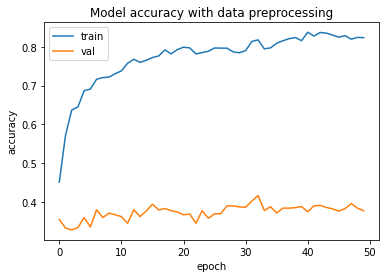

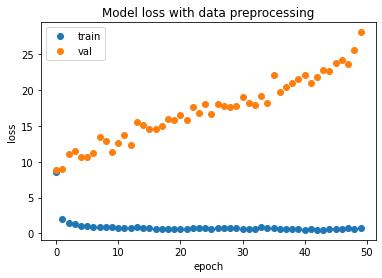

In [128]:
## Test scores for each type of augmentation
for ix, name in enumerate(["avg", "max", "sub0", "sub1"]):
  score = rnn_model.evaluate(X_test[ix], y_test[ix], verbose=0)
  print(f'Test accuracy of the CNN model on X-{name}:',score[1])

## Test scores for mode prediction over augmentations
correct = np.argmax(y_test[0], axis=1)
pred_avg = np.argmax(rnn_model(X_test[0], training=False), axis=1)
pred_max = np.argmax(rnn_model(X_test[1], training=False), axis=1)
pred_sub0 = np.argmax(rnn_model(X_test[2], training=False), axis=1)
pred_sub1 = np.argmax(rnn_model(X_test[3], training=False), axis=1)
predicted = np.vstack((pred_avg, pred_max, pred_sub0, pred_sub1)).T

predicted_mode = scs.mode(predicted, axis=1).mode.flatten()
print("Mode Accuracy:", np.sum(predicted_mode == correct) / correct.shape[0])

plot_accuracy_loss(rnn_results.history)

In [ ]:
train = (X_train, y_train, person_train)
valid = (X_valid, y_valid, person_valid)
test  = (X_test[0],  y_test[0],  person_test[0])
rnn_type = 'lstm'
for person_ix in range(9):
  print()
  for everyone in 0, 40, 50:
    person.question_1(build_RNN_model(rnn_type), train, valid, test, person_ix, everyone_epochs=everyone)

# I (Henry) am not using the models below which are:
- 'Building a basic CNN-LSTM...' which is Tonmoy's provided CNN-LSTM example
- 'LSTM I guess' which is my modification of Tonmoy's example, probably with worse accuracy

## Building a basic CNN-LSTM model and then training, validating and testing it.

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 50

#Building the model
cnn_lstm_model = Sequential([Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', Dropout=dropout, input_shape=(250,1,22)),
                             MaxPooling2D(pool_size=(3,1), padding='same'),
                             BatchNormalization(),
                             Dropout(dropout),
                             Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', Dropout=dropout),
                             MaxPooling2D(pool_size=(3,1), padding='same'),
                             BatchNormalization(),
                             Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', Dropout=dropou),
                             
                             ])
cnn_lstm_model = Sequential()

# First block of conv.
cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# Second block of conv.
cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# Third block of conv.
cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Dropout(dropout))

# FC+LSTM layer
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense((50)))
cnn_lstm_model.add(Reshape((50,1)))
cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))

# FC layer
cnn_lstm_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_lstm_model.summary()

# Training and validating the model

cnn_lstm_results = cnn_lstm_model.fit(X_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid, y_valid), verbose=True)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_84 (Dropout)         (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 28, 1, 50)       

KeyboardInterrupt: ignored

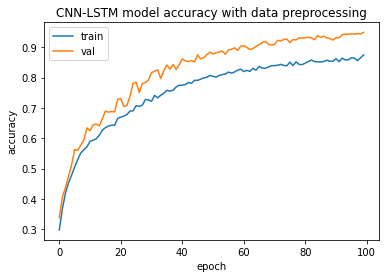

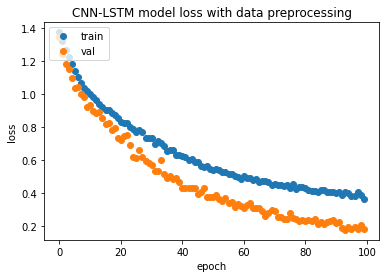

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_lstm_results.history['accuracy'])
plt.plot(cnn_lstm_results.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_lstm_results.history['loss'],'o')
plt.plot(cnn_lstm_results.history['val_loss'],'o')
plt.title('CNN-LSTM model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN-LSTM model

score = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy of the CNN-LSTM model:',score[1])

Test accuracy of the CNN-LSTM model: 0.6834085583686829


## LSTM I guess

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 100

#Building the model

lstm_model = Sequential()

# lstm_model.add()
# First block of conv.
lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(dropout))

# Second block of conv.
lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(dropout))

# Third block of conv.
lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(dropout))

# Input Shape = (?, 10, 1, 100) = (?, Time, Channels, Filters)
# lstm_model.add(Conv2D(filters=200, kernel_size=(1,), padding='valid', activation='elu'))
# lstm_model.add(Permute((1,3,2)))
# lstm_model.add(MaxPooling2D(pool_size=(1, 3), padding='same'))
# lstm_model.add(BatchNormalization())
# lstm_model.add(Dropout(dropout))

# FC+LSTM layer
# lstm_model.add(Reshape((10,34)))
# lstm_model.add(Flatten())
# lstm_model.add(Dense((50)))
lstm_model.add(Reshape((10,50)))
lstm_model.add(LSTM(25, dropout=0.5, recurrent_dropout=0.5, input_shape=(10,50), return_sequences=False))

# FC layer
# lstm_model.add(Dense(34, activation='softmax'))
lstm_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
lstm_model.summary()

# Training and validating the model
lstm_results = lstm_model.fit(X_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(X_valid, y_valid), verbose=True)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_90 (Dropout)         (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 28, 1, 50)       

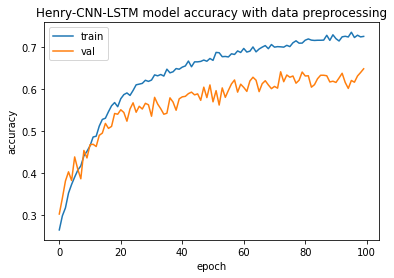

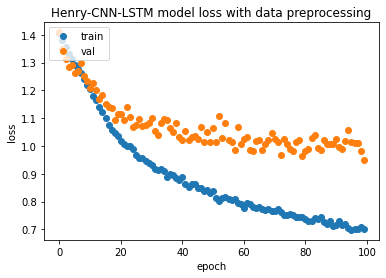

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(lstm_results.history['accuracy'])
plt.plot(lstm_results.history['val_accuracy'])
plt.title('Henry-CNN-LSTM model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lstm_results.history['loss'],'o')
plt.plot(lstm_results.history['val_loss'],'o')
plt.title('Henry-CNN-LSTM model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN-LSTM model
score = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy of the Henry-CNN-LSTM model:',score[1])

Test accuracy of the Henry-CNN-LSTM model: 0.6196388006210327


## Evaluation across people

In [ ]:
def train_person(model, x_train, y_train, x_valid, y_valid, person, batch_size=64, epochs=100):
  # results = []
  return model.fit(x_valid, y_valid,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_valid, y_valid))

def evaluate_person(model, x_test, y_test, person_test, person):
  mask = (person_test == person).flat
  x_test = x_test[mask]
  y_test = y_test[mask]
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test accuracy on Person', person, ':', score[1])

In [ ]:
# train_person(lstm_model, x_train, y_train, x_valid, y_valid, 1, batch_size=64, epochs=epochs//2)
evaluate_person(lstm_model, x_test, y_test, person_test_prep, 1)

Test accuracy on Person 1 : 0.5099999904632568
